# "Boosting - interaktive Version"
> "Erklärungen und Implementierungen zur Lehrprobe zum Thema Boosting."

- toc:true- branch: master
- badges: true
- comments: true
- author: Alexander Dockhorn
- categories: [fastpages, jupyter]

# Boosting

Dieses Jupyter Notebook leitet durch die Entwicklung eines Adaboost Klassifikators und begleitet meinen Vortrag 
zur Lehrprobe and der Universität Rostock. In diesem Notebook werden die folgenden Themen besprochen:

- Visualisieren eines Trainingsdatensatzes
- Erlernen eines Entscheidungsbaums
- Erlernen eines Entscheidungsstumpfs
- Training von Adaboost
    - Update der Trainingsbeispielgewichte
    - Auswahl des optimalen Klassifikators
    - Auswahl des optimalen Klassifikatorgewichts
- Analyse des Trainingsverlaufs
    - Schrittweise Anpassung des Ensembles
    - Vergleich von Trainingsfehler und Verlustfunktion
    - Beispiele für Overfitting und Early Stopping
  

Zunächst folgt der Import genereller Bibliotheken, welche im Verlauf dieses Notebooks verwendet werden:

In [109]:
# generelle imports 
import numpy as np                      # Matrizen und Vektoren
from typing import Optional             # type hints
import matplotlib.pyplot as plt         # Visualisierung der Ergebnisse
import matplotlib as mpl                # shortcut für einige Visualisierungsklassen

# Implementierung von Entscheidungsbäumen
from sklearn.tree import DecisionTreeClassifier     

# Funktionen zum Generieren von Trainingsbeispielen
from sklearn.datasets import make_moons, make_circles, make_classification

## Funktion zur Visualisierung der Ergebnisse

Um die Ergebnisse gelernter Klassifikatoren zu visualisieren, wird die folgende Funktion bereitgestellt.
Hierbei wird davon ausgegangen, dass der Datensatz aus 2 dimensionalen Punkten besteht, welche jeweils durch
+1 oder -1 gelabelet wurden.

Positiv zu klassifizierende Punkte werden durch ein rotes Plus-Zeichen dargestellt, wohingehen negativ zu 
klassifizierende Punkte durch einen blauen Kreis dargestellt werden. Optional kann die Ausgabe eines Klassifikators
durch die rote oder blaue Hinterlegung des Hintergrunds dargestellt werden, wohingegen vom Klassifikator falsch 
klassifizierte Datenpunkte eingekreist werden.

Weitere optionale Funktionen werden in der Funktionsbeschreibung gelistet.

In [110]:
def plot_results (X: np.ndarray,
                  y: np.ndarray,
                  clf=None,
                  sample_weights: Optional[np.ndarray] = None,
                  annotate: bool = False,
                  ax: Optional[mpl.axes.Axes] = None,
                  size_factor=1,
                  fontsize=16,
                  pad = 1,
                  highlight_errors=True) -> None:
    """ 
        Plot ± Trainingsdaten in 2D, 
        optional kann die Ausgabe des Klassifikators als Hintergrundfarbe hinzugefügt werden,
        ebenfalls optional kann die Gewichtung als Label eines jeden Datenpunkts hinzugefügt werden
    
    :param X:  Trainingsdaten 
    :param y:  Trainingslabels
    :param clf:  Klassifikator
    :param sample_weights:  Gewichte der Trainingsbeispiele
    :param annotate: if true: Schreibe die Werte aus sample_weights an jeden Datenpunkt
    :param ax: MPL-Axis object welches zum plotten des Ergebnis verwendet werden soll
    :param size_factor:  Skalierung der Trainingsdatenpunkte, um Größenunterschiede hervorzuheben
    :param fontsize:  fontsize sämtlicher Beschriftungen
    :param pad: Größe des weißen Bereichs links, rechts, über und unter den Datenpunkten
    :param highlight_errors: falsche Klassifikationen einkreisen
    :return: MPL axis object
    """

    assert set(y) == {-1, 1}, 'Label müssen +1 oder -1 sein.'

    # sollte keine Axis Object gegeben sein, wird eine neue Figure erstellt
    if not ax:
        fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
        fig.set_facecolor('white')

    # Plotgrenzen abhängig von min und max Werten des Datensatzes und einem zusätzlichen weißen Rand
    x_min, x_max = X[:, 0].min() - pad, X[:, 0].max() + pad
    y_min, y_max = X[:, 1].min() - pad, X[:, 1].max() + pad

    # Berechnung der Markergrößen
    if sample_weights is not None:
        sizes = np.array(sample_weights) * X.shape[0] * 100
    else:
        sizes = np.ones(shape=X.shape[0]) * 100

    # plotten positiv zu klassifizierender Datenpunkte
    X_pos = X[y == 1]
    sizes_pos = sizes[y == 1]
    ax.scatter(*X_pos.T, s=sizes_pos*size_factor, marker='+', color='red')

    # plotten negativ zu klassifizierender Datenpunkte
    X_neg = X[y == -1]
    sizes_neg = sizes[y == -1]
    ax.scatter(*X_neg.T, s=sizes_neg*size_factor, marker='.', c='blue')

    if clf:
        # Ausgabe des Klassifikators als blau/rote Hinterlegung
        plot_step = 0.01
        xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                             np.arange(y_min, y_max, plot_step))

        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        
        # If all predictions are positive class, adjust color map acordingly
        if list(np.unique(Z)) == [1]:
            fill_colors = ['r']
        else:
            fill_colors = ['b', 'r']

        ax.contourf(xx, yy, Z, colors=fill_colors, alpha=0.2)
        
        # einkreisen falsch klassifizierter Datenpunkte
        if highlight_errors:
            error = (clf.predict(X) != y)
            ax.scatter(*X[error].T,  s=250, facecolors='none', edgecolors='black')
        
    # Beschriftung der Datenpunkte
    if annotate:
        if sample_weights is None:
            for i, (x, y) in enumerate(X):
                offset = 0.05
                ax.annotate(f'$x_{i + 1}$', (x + offset, y - offset))
        else:
            for (i, (x, y)), weight in zip(enumerate(X), sample_weights):
                offset = 0.05
                ax.annotate(f'${weight}$', (x + offset, y + 0.1), fontsize=fontsize)# - offset))
                
    # Achsenbeschriftung
    ax.set_xlim(x_min+0.5, x_max-0.5)
    ax.set_ylim(y_min+0.5, y_max-0.5)
    ax.set_xlabel('$x_1$', fontsize=16)
    ax.set_ylabel('$x_2$', fontsize=16)
    

## Erstellen eines Trainingsdatensatzes

Wähle eine der folgenden Beispieldatensätze aus oder erzeuge einen eigenen.
Für die korrekte Durchführung von Adaboost müssen die Label -1 und +1 für die
Unterscheidung der beiden Klassen verwendet werden.

Die Funktion label_preprocessing kann verwendet werden um die Label von anderen Datensätzen zu transformieren.

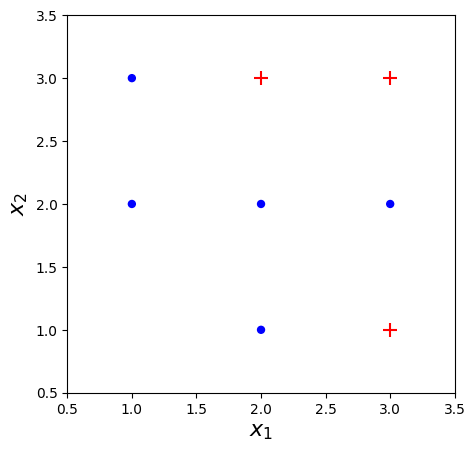

In [111]:
def generate_trainingdata():
    X = np.array([[1, 2],
                  [1, 3],
                  [2, 1], 
                  [2, 3],
                  [3, 1], 
                  [3, 2],
                  [3, 3],
                  [2, 2]])

    y = np.array([-1, -1, -1, +1, +1, -1, +1, -1])
    return X, y

def label_preprocessing(y):
    values = np.unique(y)
    
    # Labels sind bereits +1 oder -1
    if 1 in values and -1 in values:
        return y
    
    assert len(values) == 2, 'Es müssen 2-Klassenprobleme verwendet werden!'
    new_labels = np.zeros(y.shape)
    new_labels[y==values[0]] = -1
    new_labels[y==values[1]] = +1
    return new_labels

# wähle einen der folgenden Trainingsdatensätze durch auskommentieren aller anderen
X, y = generate_trainingdata()
#X, y = make_classification(n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=1)
#X, y = make_moons(noise=0.1)
#X, y = make_circles(noise=0.1)

# es kann nötig sein die Label auf +1 und -1 anzupassen. Die folgende Funktion übernimmt diese Aufgabe wenn genau 2
# Ziellabel existieren
y = label_preprocessing(y)

# Visualisierung der Trainingsdaten
plot_results(X, y)

## Lernen eines Entscheidungsbaums

Wir hatten bereits in einer vorherigen Veranstaltung die Implementierung von Entscheidungsbäumen thematisiert.
Dieses mal greifen wir auf die Implementierung von scikit-learn zurück.

Eine Übersicht aller Parameter finden sie hier:

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier

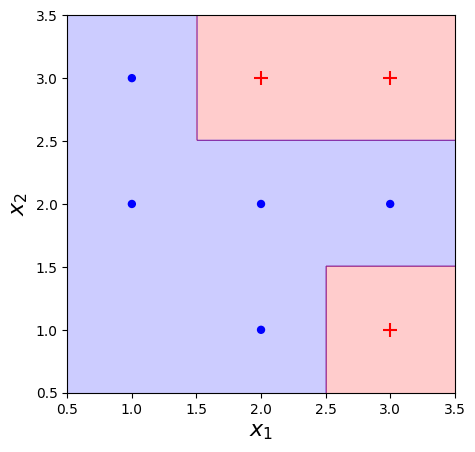

In [112]:
# Definition des zu verwendenden Klassifikators
dt = DecisionTreeClassifier()

# Durchführen des Trainings bezüglich der gegebenen Daten X und der Ziellabel y
dt.fit(X, y)

# Darstellung des Ergebnisses
plot_results(X, y, dt)

Sklearn erlaubt die Begrenzung des Entscheidungsbaums anhang von Schwellenwerten.
Um einen Entscheidungsstumpf zu lernen reduzieren wir die maximale Tiefe auf 1.
Beachte die Fehlklassifikationen des Entscheidungsstump im nachfolgenden Plot.

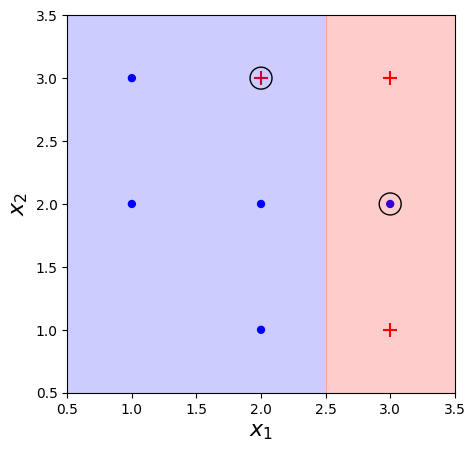

In [113]:
stump = DecisionTreeClassifier(max_depth=1)
stump.fit(X, y)
plot_results(X, y, stump)


## Adaptive Boosting (Adaboost)

    

## Definition von AdaBoost

In den folgenden Codeabschnitten werden wir schrittweise den Adaboost Classifier erstellen.
Wir beginnen mit der Definition der Basisklasse, welche die Entscheidungsstümpfe, deren Gewichte,
die Gewichte unserer Trainingsdaten und den Fehler des Klassifikators speichert.

In [114]:
class AdaBoost:
    """ AdaBoost enemble classifier from scratch """

    def __init__(self, random_state=0):
        self.stumps = None                  # Placeholder für ein Array von Entscheidungsstümpfen
        self.stump_weights = None           # Placeholder für ein Array von Klassifikatorgewichten
        self.errors = None                  # Placeholder für ein Array des gewichteten Trainingsfehlers
        self.sample_weights = None          # Placeholder für ein Array der Trainingsbeispielgewichte
        self.random_state = random_state    # random_state um bei gleichen seed die gleiche Ausgabe zu ermöglichen

Als nächstes fügen wir unserer AdaBoost-Klasse die Trainingsfunktionen hinzu.
Hierbei überprüft die _check_X_y funktion ob die Ziellabel in der Menge -1 und +1 entsprechen.
Die fit Funktion definiert den Trainingsablauf wie wir ihn kennengelernt haben.

In [115]:
def _check_X_y(self, X, y):
    """ Validate assumptions about format of input data
    
    :param self:  benötigt, um als Memberfunktion aufrufbar zu sein
    :param X: Trainingsdaten beliebiger Dimensionszahl
    :param y: Ziellabel y_i in {-1, +1}
    :return: X, y
    """
    assert set(y) == {-1, 1}, 'Response variable must be ±1'
    return X, y

def fit(self, X: np.ndarray, y: np.ndarray, iters: int):
    """  Fit the model using training data 
    
    :param self: benötigt, um als Memberfunktion aufrufbar zu sein
    :param X: Trainingsdaten beliebiger Dimensionszahl
    :param y: Ziellabel y_i in {-1, +1}
    :param iters: Anzahl der zu lernenden Entscheidungsstümpfe
    :return: Adaboost Ensemble
    """

    # Überprüfe Label
    X, y = self._check_X_y(X, y)

    # Initialisiere Arrays zum Speichern der Zwischenschritte
    n = X.shape[0]
    self.sample_weights = np.zeros(shape=(iters, n))
    self.stumps = np.zeros(shape=iters, dtype=object)
    self.stump_weights = np.zeros(shape=iters)
    self.errors = np.zeros(shape=iters)

    # initialize weights uniformly
    self.sample_weights[0] = np.ones(shape=n) / n

    # lerne schrittweise einen neuen Klassifikator und füge ihn dem Array hinzu
    for t in range(iters):
        
        # definiere und trainiere Entscheidungsstumpf wie zuvor gesehen
        curr_sample_weights = self.sample_weights[t]
        stump = DecisionTreeClassifier(max_depth=1, max_leaf_nodes=2, random_state=self.random_state)
        stump = stump.fit(X, y, sample_weight=curr_sample_weights)

        # Berechne den gewichteten Fehler des neuen Klassifikators
        stump_pred = stump.predict(X)
        err = curr_sample_weights[(stump_pred != y)].sum()
        
        # Berechne das Gewicht des Klassifikators
        stump_weight = np.log((1 - err) / err)
        
        # Aktualisiere die Gewichte der Trainingsbeispiele
        new_sample_weights = (
            curr_sample_weights * np.exp(-0.5*stump_weight * y * stump_pred)
        )
        
        # Normalisiere die Gewichte der Trainingsbeispiele
        new_sample_weights /= new_sample_weights.sum()

        # Speicher die Gewichte für die nächste Iteration
        if t+1 < iters:
            self.sample_weights[t+1] = new_sample_weights

        # Speichere den trainierten Entscheidungsstump
        self.stumps[t] = stump
        self.stump_weights[t] = stump_weight
        self.errors[t] = err

    return self

# hinzufügen der soeben erstellen Methoden zur Klasse AdaBoost
# Achtung: normalerweise nicht empfohlen, aber es ermöglicht uns an dieser Stelle die Schritte einzeln zu kommentieren
AdaBoost._check_X_y = _check_X_y
AdaBoost.fit = fit

Als nächstes fügen wir die Klassifikationsfunktionen hinzu.
Predict_proba gibt die graduelle Ausgabe des Ensembles aus, wohingegen predict die Labels -1 und 1 ausgibt.

In [116]:
def predict(self, X):
    """ Gibt Label der Form -1 oder +1 aus
    
    :param self: benötigt, um als Memberfunktion aufrufbar zu sein
    :param X: Testdaten mit gleicher Dimensionszahl wie die Trainingsdaten
    :return: 
    """
    # bestimme das Vorzeichen der gewichteten Summe zur Ausgabe von +1 und -1 pro Datenpunkt
    return np.sign(self.predict_proba(X))


def predict_proba(self, X):
    """ Gibt die graduelle Ausgabe des Ensembles aus
    
    :param self: benötigt, um als Memberfunktion aufrufbar zu sein
    :param X: Testdaten mit gleicher Dimensionszahl wie die Trainingsdaten
    :return: 
    """
    # bestimme die Vorhersage jedes Klassifikators für jeden Datenpunkt X
    stump_preds = np.array([stump.predict(X) for stump in self.stumps])
    # gib die gewichtete Summe aus
    return np.dot(self.stump_weights, stump_preds)

# hinzufügen der soeben erstellen Methoden zur Klasse AdaBoost
# Achtung: normalerweise nicht empfohlen, aber es ermöglicht uns an dieser Stelle die Schritte einzeln zu kommentieren
AdaBoost.predict = predict
AdaBoost.predict_proba = predict_proba

Es wird Zeit den Adaboost Klassifikator zu testen:

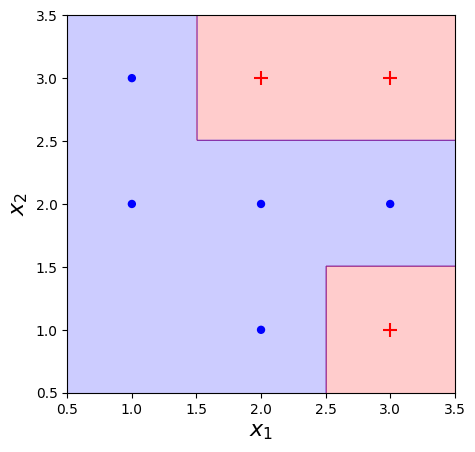

In [117]:
iters = 10
ada = AdaBoost()
ada.fit(X, y, iters)
plot_results(X, y, ada)

Im nächsten Schritt schauen wir uns die graduelle Ausgabe des Klassifikators an.

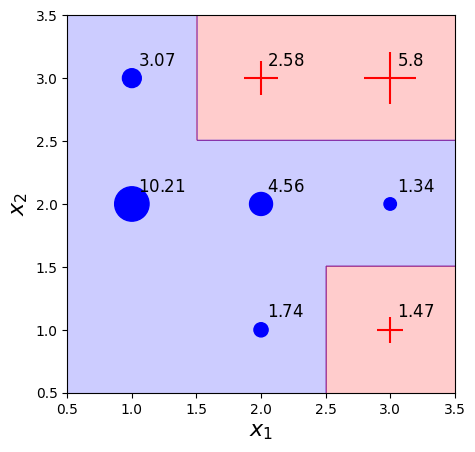

In [118]:
plot_results(X, y, ada, annotate=True, sample_weights=np.abs(np.round(ada.predict_proba(X),2)), size_factor=0.3, fontsize=12)

Um den Trainingsverlauf zu visualisieren, definieren wir eine Hilfsfunktion, welche ein bestehendes Ensemble
auf die ersten t Klassifikatoren reduziert.

In [119]:
def truncate_adaboost(self, t: int):
    """ Truncate a fitted AdaBoost up to (and including) a particular iteration """
    assert t > 0, 't must be a positive integer'
    from copy import deepcopy
    new_clf = deepcopy(self)
    new_clf.stumps = self.stumps[:t]
    new_clf.stump_weights = self.stump_weights[:t]
    return new_clf

AdaBoost.truncate_adaboost = truncate_adaboost

In der folgenden Darstellung zeigen die Plots in der ersten Reihe die gelernten Entscheidungsstümpfe,
wohingegen die zweite Reihe den jeweils aktuellen Zustand des Ensembles darstellt.
Von links nach rechts werden die Zeitschritte 1 bis iter dargestellt.

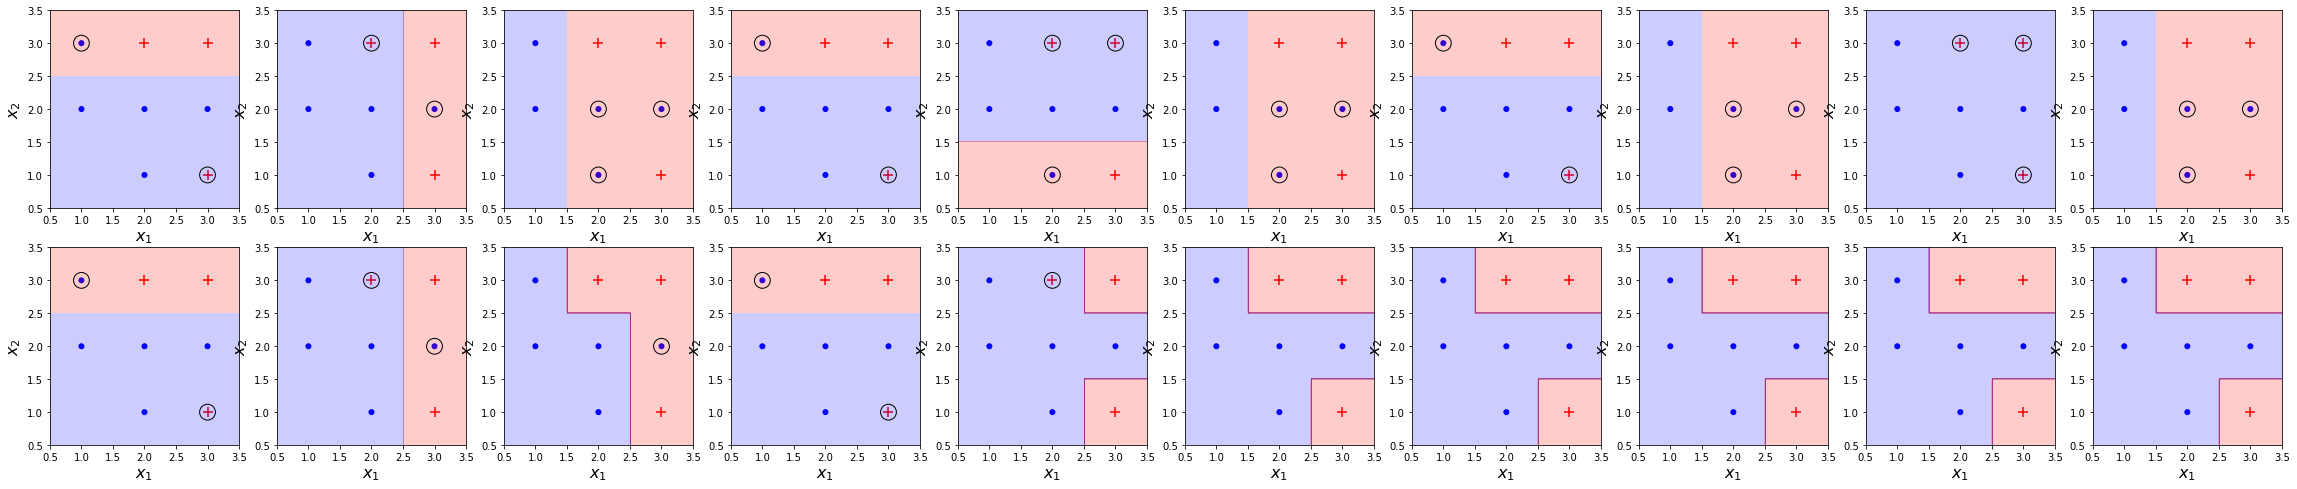

In [120]:
fig, ax = plt.subplots(2, iters, figsize=(iters*4,8))
for i in range(1, iters+1):
    truncated_ada = ada.truncate_adaboost(i)
    plot_results(X, y, truncated_ada.stumps[i-1], ax = ax[0, i-1])
    plot_results(X, y, truncated_ada, ax = ax[1, i-1])

## Analyse des Trainingverlaufs

Wir schauen uns nun die einzelnen Fehlerfunktionen im Vergleich an. Hierbei beobachten wir den 
Klassifikationsfehler, den gewichteten Klassifikationsfehler und den exponentiellen Fehler pro Iteration.

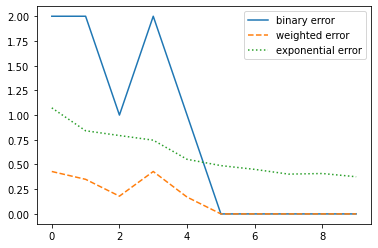

In [121]:
binary_error = np.zeros(iters)
weighted_error = np.zeros(iters)
exponential_error = np.zeros(iters)

for i in range(1, iters+1):
    truncated_ada = ada.truncate_adaboost(i)
    binary_error[i-1] = np.sum(truncated_ada.predict(X) != y)
    weighted_error[i-1] = np.sum(np.array(truncated_ada.predict(X) != y) * truncated_ada.sample_weights[-1])
    exponential_error[i-1] = np.sum(truncated_ada.sample_weights[-1] * np.exp(-0.5 * y * truncated_ada.predict_proba(X)))

plt.plot(binary_error, linestyle = "solid", label="binary error")
plt.plot(weighted_error, linestyle = "dashed", label="weighted error")
plt.plot(exponential_error, linestyle = "dotted", label="exponential error")
plt.legend()
plt.show()

Bei der vorherigen Darstellung ist zu sehen, dass, selbst wenn der Trainingsfehler bereits 0 ist,
AdaBoost weiter den exponentiellen Fehler minimiert. Insbesondere bei komplexen Datensätzen kommt es
hierdurch zur Maximierung des Abstands zwischen Trainingspunkten und der Trennebene des Klassifikators.

Eine solche Maximierung des Margins ist uns bereits aus Support Vector Maschinen bekannt!

## Overfitting und Early Stopping

Durch den permanten Drang den exponentiellen Fehler zu minimieren, wird Adaboost im Falle von
Outliern irgendwann overfitten. Dies kann jedoch eine enorme Anzahl an Iterationen dauern.

Da die recheneffiziente Matrixmultiplikation einen zu hohen RAM-Bedarf hat, tauschen wir die
predict_proba Funktion mit einer weniger schnellen, dafür auch weniger speicheraufwändigen Version aus.

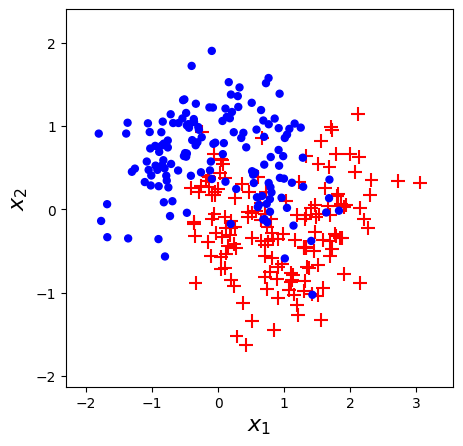

In [122]:
def predict_proba(self, X):
    """ Gibt die graduelle Ausgabe des Ensembles aus

    :param self: benötigt, um als Memberfunktion aufrufbar zu sein
    :param X: Testdaten mit gleicher Dimensionszahl wie die Trainingsdaten
    :return:
    """
    # bestimme die Vorhersage jedes Klassifikators für jeden Datenpunkt X
    result = np.zeros(X.shape[0])
    for stump, weight in zip(self.stumps, self.stump_weights):
        result += stump.predict(X) * weight
    # gib die gewichtete Summe aus
    return result

AdaBoost.predict_proba = predict_proba

X, y = make_moons(300, noise=0.4, random_state=0)
y = label_preprocessing(y)
plot_results(X, y)

ada = AdaBoost()
ada.fit(X,y, 5000)

Das folgende Beispiel stellt das Ensemble nach 1, 5, 10, 50, 100, 500, 1000, und 5000 Schritten dar.
Beobachte wie das Ensemble bereits nach 50 Schritten eine grobe Unterteilung der beiden Klassen ermöglicht.
Insbesondere in den letzten beiden dargestellten Ensemblen (t=1000 und t=5000) zerfallen die sauberen Grenzen
des Ensembles und immer mehr Ausreißer werden durch das Ensemble abgebildet.

Durch die Verknüpfung einzelner stark gewichteter Entscheidungsstümpfe entsteht ein Flickenteppich aus
positiv und negativ zu klassifizierenden Bereichen.

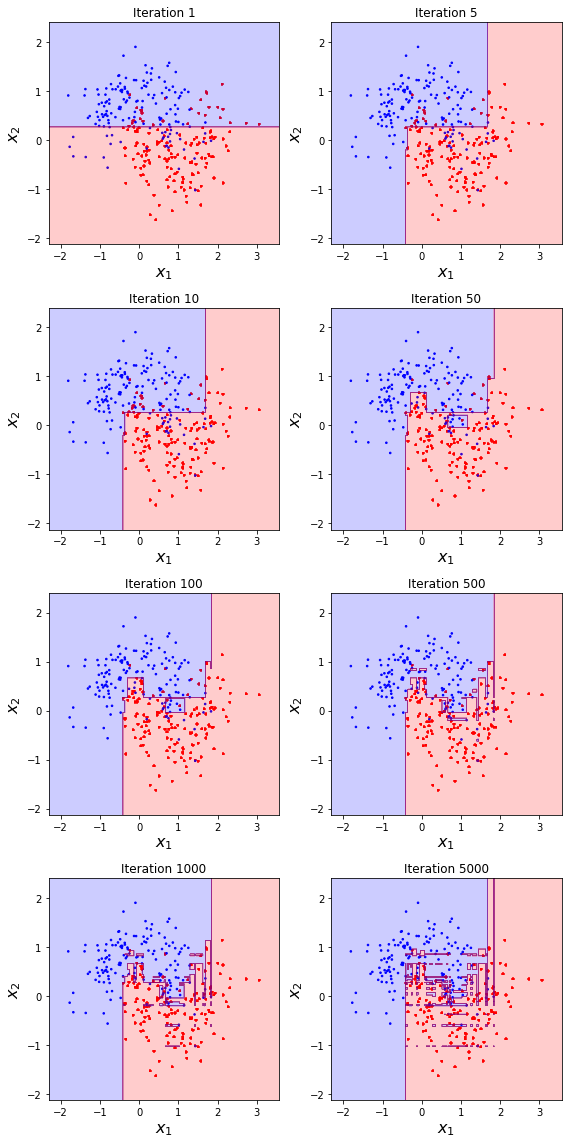

In [123]:
fig, ax = plt.subplots(4, 2, figsize=(8, 16))
for i, t in enumerate([1, 5, 10, 50, 100, 500, 1000, 5000]):
    truncated_ada = ada.truncate_adaboost(t)
    plot_results(X, y, truncated_ada, ax=ax[i//2, i%2], size_factor=0.1, highlight_errors=False)
    ax[i//2, i%2].set_title("Iteration " + str(t))
plt.tight_layout()
plt.savefig("ensemble.pdf")
plt.show()

Diese Überanpassung lässt sich wie bereits erwähnt durch die dauerhafte Anpassung an den exponentiellen
Fehler erklären. Diese Anpassung wird deutlich, wenn man den binären Fehler und den exponentiellen Fehler
über den Verlauf der Iterationen plottet.

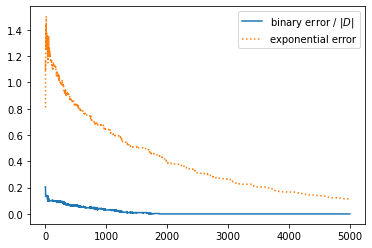

In [124]:
binary_error = np.zeros(5000)
exponential_error = np.zeros(5000)

prediction = np.zeros(X.shape[0])
for i in range(1, 5001):
    np.zeros(X.shape[0])
    prediction += ada.stumps[i-1].predict(X) * ada.stump_weights[i-1]
    labels = np.sign(prediction)

    binary_error[i-1] = np.sum(labels != y) / X.shape[0]
    exponential_error[i-1] = np.sum(ada.sample_weights[i-1] * np.exp(-0.5 * y * prediction))

plt.plot(binary_error, linestyle = "solid", label=r"binary error / $\vert D\vert$")
plt.plot(exponential_error, linestyle = "dotted", label="exponential error")
plt.legend()
plt.show()

## Vermeidung von Overfitting

Wie auch bei anderen Klassifikatoren, können wir dieses Problem vermeiden, wenn wir den Datensatz
zunächst in einen Trainings- und Testdatensatz aufteilen und den Fehler über den Verlauf der Iterationen
auf diesen beiden Datensätzen beobachten.

Hierfür teilen wir zunächst den Datensatz in zwei Mengen auf wobei 70% der Beispiele als Trainingsdaten
und 30% als Testdaten verwendet werden. Nachfolgend trainieren wir AdaBoost auf den Trainingsdaten.

In [125]:
from sklearn.model_selection import train_test_split
[X_train, X_test, y_train, y_test] = train_test_split(X, y, test_size=0.3)

ada = AdaBoost()
ada.fit(X_train,y_train, 1000)

Als nächstes messen wir den binären Fehler der Trainings- und Testdaten per Iteration und stellen diese
in gewohnter Weise grafisch dar.

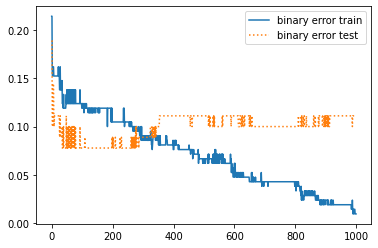

In [126]:
binary_error_train = np.zeros(1000)
binary_error_test = np.zeros(1000)

prediction_train = np.zeros(X_train.shape[0])
prediction_test = np.zeros(X_test.shape[0])
for i in range(1, 1001):
    prediction_train += ada.stumps[i-1].predict(X_train) * ada.stump_weights[i-1]
    prediction_test += ada.stumps[i-1].predict(X_test) * ada.stump_weights[i-1]

    binary_error_train[i-1] = np.sum(np.sign(prediction_train) != y_train) / X_train.shape[0]
    binary_error_test[i-1] = np.sum(np.sign(prediction_test) != y_test) / X_test.shape[0]

plt.plot(binary_error_train, linestyle = "solid", label=r"binary error train")
plt.plot(binary_error_test, linestyle = "dotted", label="binary error test")
plt.legend()
plt.show()


Nach einer anfänglichen Phase in welcher der Klassifikationsfehler für die Trainings- und Testdaten
reduziert werden konnte, stagniert die Verbesserung bezüglich der Testdaten und steigt phasenweise
sogar wieder an. Demnach findet von diesem Moment an nur noch eine Überanpassung an den Trainingsdatensatz statt.
In diesem Fall können wir das Training vorzeitig abbrechen.

Wir reduzieren den Plot auf die ersten 100 Zeitschritte um den Abbruchpunkt bestmöglich zu bestimmen.

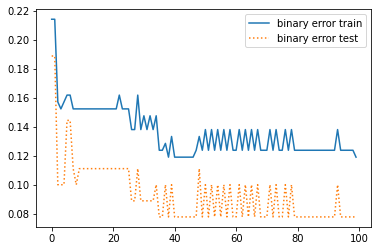

In [127]:
binary_error_train = np.zeros(100)
binary_error_test = np.zeros(100)

prediction_train = np.zeros(X_train.shape[0])
prediction_test = np.zeros(X_test.shape[0])
for i in range(1, 101):
    prediction_train += ada.stumps[i-1].predict(X_train) * ada.stump_weights[i-1]
    prediction_test += ada.stumps[i-1].predict(X_test) * ada.stump_weights[i-1]

    binary_error_train[i-1] = np.sum(np.sign(prediction_train) != y_train) / X_train.shape[0]
    binary_error_test[i-1] = np.sum(np.sign(prediction_test) != y_test) / X_test.shape[0]

plt.plot(binary_error_train, linestyle = "solid", label=r"binary error train")
plt.plot(binary_error_test, linestyle = "dotted", label="binary error test")
plt.legend()
plt.show()

Die genaue Bestimmung des Abbruchzeitpunkts ist zumeist schwer zu bestimmen.
Ziel ist es, den Trainingsfehler **und** den Testfehler zu minimieren.
Zumeist steigt der Testfehler aber wieder an, während der Trainingsfehler weiter sinkt.
Im folgenden Beispiel werden die Zeitunkte 20, 30, 40 und 450 miteinander verglichen.

Durch das Hinzufügen weiterer Klassifikatoren in das Ensemble, können zunehmend mehr Trainingsdaten
richtig klassifiziert werden. Hierfür steigt die Komplexität der Entscheidungsgrenze des Ensembles
und nimmt langsam die Form der Datenverteilung an. Gegeben der folgenden 4 Bilder scheint 40 ein
interessanter Abbruchpunkt zu sein.

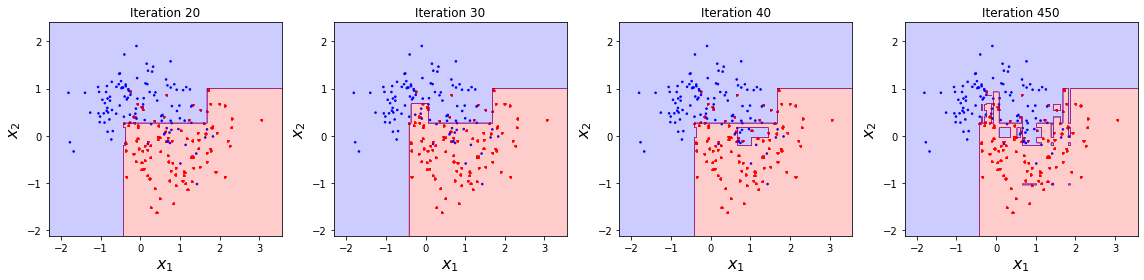

In [128]:
fig, ax = plt.subplots(1, 4, figsize=(16, 4))
for i, t in enumerate([20, 30, 40, 450]):
    truncated_ada = ada.truncate_adaboost(t)
    plot_results(X_train, y_train, truncated_ada, ax=ax[i], size_factor=0.1, highlight_errors=False)
    ax[i].set_title("Iteration " + str(t))
plt.tight_layout()
plt.show()